In [2]:
import datetime as dt
import os
from os.path import join, exists, abspath
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import cartopy.crs as ccrs
import intermag as im
from scipy import interpolate

In [3]:
start_date = dt.datetime(2025, 1, 15)
num_days   = 1

In [4]:
datasets = dict()

for station in tqdm(im.IAGA_CODES):
    fdir = join(abspath(''), station)
    
    if not exists(fdir):
        os.makedirs(fdir)
    
    datasets[station] = im.IM_Dataset()
    datasets[station].download_dataset(iaga_code    = station,
                                        resolution   = 'sec',
                                        start_date   = start_date,
                                        load_dataset = True,
                                        num_days     = num_days,
                                        save_dir     = join(abspath(''), station),
                                        append       = True)

stations = deepcopy(list(datasets.keys()))
for station in stations:
    if not datasets[station].data().LONG.size:
        datasets.pop(station)

100%|██████████| 152/152 [00:52<00:00,  2.92it/s]


In [8]:
# Sample data (replace with your actual data)
lons = [datasets[station].data().LONG[0] for station in datasets.keys()]
lats = [datasets[station].data().LAT[0]  for station in datasets.keys()]
data = [datasets[station].data().F[0]    for station in datasets.keys()]
locs = list(map(list, zip(lons, lons)))

num_lon = 100
num_lat = 100
new_shape = (num_lon, num_lat)
new_lons = np.linspace(-180, 180, num_lon)
new_lats = np.linspace(-90, 90, num_lat)
new_lons, new_lats = np.meshgrid(new_lons, new_lats)

In [9]:
rbfi_scalar = interpolate.RBFInterpolator(locs,
                                          data,
                                          kernel='linear',
                                          smoothing=0)
interp_scalar = rbfi_scalar(np.hstack([new_lons.flatten()[:, np.newaxis],
                                       new_lats.flatten()[:, np.newaxis]])).reshape(new_shape)

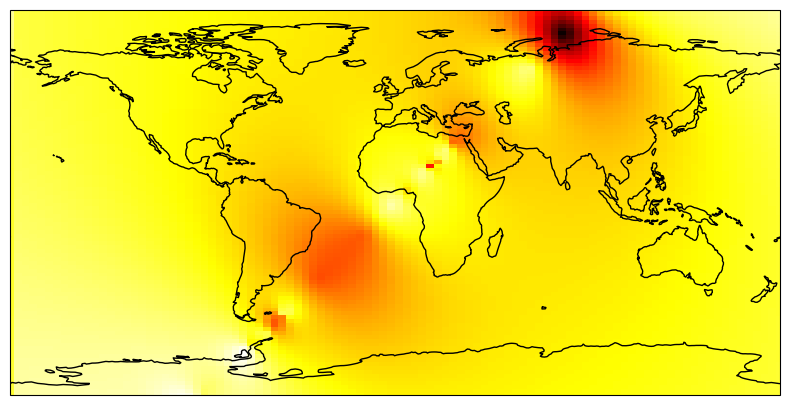

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
heatmap = ax.pcolormesh(new_lons, new_lats, interp_scalar, cmap='hot', transform=ccrs.PlateCarree())
plt.show()

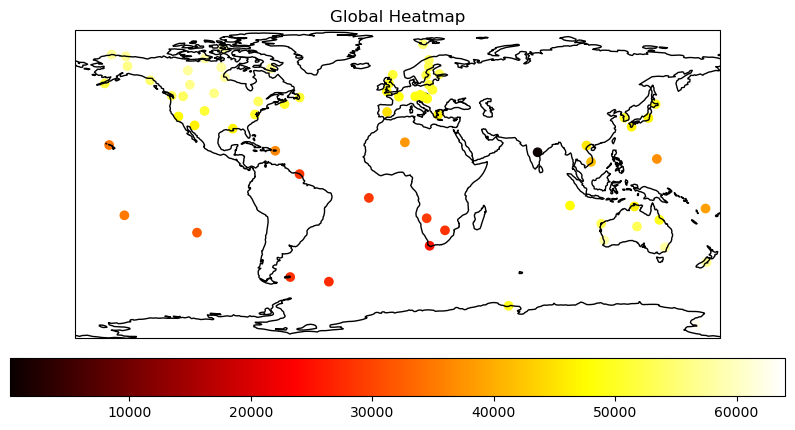

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
heatmap = ax.scatter(lons, lats, c=data, cmap='hot', transform=ccrs.PlateCarree())
plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.05)
plt.title('Global Heatmap')
plt.show()